Import necessary modules

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from astropy.time import Time 
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.constants import c
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum

In [3]:

class RunningSpectrumStats:
    def __init__(self, wl):
        self.wavelengths = wl  # Wavelength grid (assumed to be the same for all spectra)
        self.n = 0  # Number of spectra
        self.mean_flux = np.zeros_like(wl)  # Running mean flux
        self.m2 = np.zeros_like(wl)  # Sum of squared differences for variance

    def add_spectrum(self, flux):
        self.n += 1
        delta = flux - self.mean_flux
        self.mean_flux += delta / self.n
        self.m2 += delta * (flux - self.mean_flux)

    def mean_spectrum(self):
        return self.mean_flux

    def variance_spectrum(self):
        return self.m2 / (self.n - 1) if self.n > 1 else np.zeros_like(self.wavelengths)

    def stddev_spectrum(self):
        return np.sqrt(self.variance_spectrum())

In [4]:

CFHT = EarthLocation.of_site('Canada-France-Hawaii Telescope')
sc = SkyCoord.from_name('WASP 107')
GAMMA = 13.744*1e3 * (u.m/u.s)
wl_min, wl_max = 1000, 1100

# He I air from NIST
HeI_1_air= 1082.909
HeI_2_air = 1083.025
HeI_3_air = 1083.034

# Functions to convert wavelengths back and forth
def air_to_vac(wl): 
    # Convert to angs
    wl_ang = wl * 10
    wl_vac = pyasl.airtovac2(wl_ang, mode="ciddor")
    wl_vac /=10
    return wl_vac 

def vac_to_air(wl):
    wl_ang = wl*10 
    wl_air = pyasl.vactoair2(wl_ang, mode="ciddor")
    wl_air /=10
    return wl_air
#%%
HeI_1_vac = air_to_vac(HeI_1_air)
HeI_2_vac = air_to_vac(HeI_2_air)
HeI_3_vac = air_to_vac(HeI_3_air)

# Plot the Si I line 
Si_1_air = 1082.7091

Mg_1_air = 1081.1084

In [25]:
print(HeI_1_vac, HeI_2_vac, HeI_3_vac)

1083.2056477920669 1083.3216792610835 1083.3306817026466


In [5]:
def apply_doppler_correction(wl, v_star): 
    wl_0 = wl/(1 + v_star/c)
    return wl_0

In [6]:
import os

data_directory = 'data/'
fits_list = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if file.endswith('.fits')]

In [7]:
fits_list

['data/2877053s.fits',
 'data/2955163s.fits',
 'data/2955126s.fits',
 'data/2955147s.fits',
 'data/2955102s.fits',
 'data/2955098s.fits',
 'data/2875804s.fits',
 'data/2955145s.fits',
 'data/2955100s.fits',
 'data/2955161s.fits',
 'data/2955124s.fits',
 'data/2955119s.fits',
 'data/2882666s.fits',
 'data/2955165s.fits',
 'data/2955120s.fits',
 'data/2877055s.fits',
 'data/2872267s.fits',
 'data/2955158s.fits',
 'data/2876175s.fits',
 'data/2955139s.fits',
 'data/2955141s.fits',
 'data/2955104s.fits',
 'data/2955143s.fits',
 'data/2955106s.fits',
 'data/2875802s.fits',
 'data/2872690s.fits',
 'data/2872265s.fits',
 'data/2876177s.fits',
 'data/2882189s.fits',
 'data/2955167s.fits',
 'data/2955122s.fits',
 'data/2882664s.fits',
 'data/2872689s.fits',
 'data/2955101s.fits',
 'data/2955144s.fits',
 'data/2955099s.fits',
 'data/2955118s.fits',
 'data/2882663s.fits',
 'data/2955125s.fits',
 'data/2955160s.fits',
 'data/2955127s.fits',
 'data/2955162s.fits',
 'data/2877052s.fits',
 'data/2872

Filename: data/2877053s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     538   ()      
  1  UniformWavelength    1 BinTableHDU   1105   307001R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  UniformVelocity    1 BinTableHDU   1105   285377R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
Filename: data/2955163s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     536   ()      
  1  UniformWavelength    1 BinTableHDU   1103   307001R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
  2  UniformVelocity    1 BinTableHDU   1103   285377R x 17C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   
Filename: data/2955126s.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     536   ()      
  1  UniformWavelength    1 BinTableHDU   1103   307001R x 17C   [D, D, D, D, D, D, D, D, D, D, D,

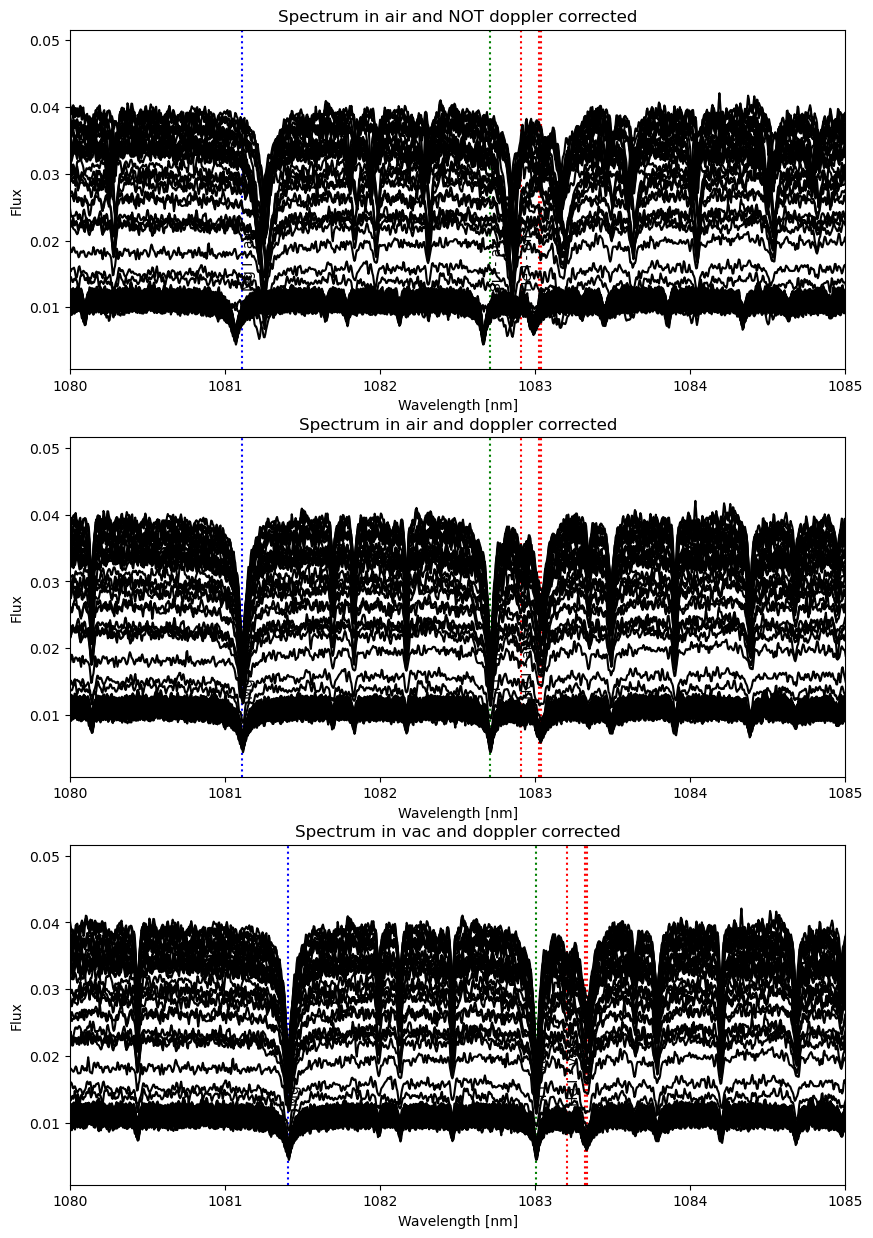

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
ax1.axvline(HeI_1_air, color='red', linestyle='dotted')
ax1.axvline(HeI_2_air, color='red', linestyle='dotted')
ax1.axvline(HeI_3_air, color='red', linestyle='dotted')
ax1.text(HeI_1_air, 0.013, 'He I - air ', rotation=90)
ax1.axvline(Si_1_air, color = 'green', ls = 'dotted')
ax1.text(Si_1_air, 0.013, 'Si I - air', rotation = 90)
ax1.axvline(Mg_1_air, color = 'blue', ls = 'dotted')
ax1.text(Mg_1_air, 0.013,  'Mg I - air', rotation=90)
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Flux')
ax1.set_title('Spectrum in air and NOT doppler corrected')

ax2.axvline(HeI_1_air, color='red', linestyle='dotted')
ax2.axvline(HeI_2_air, color='red', linestyle='dotted')
ax2.axvline(HeI_3_air, color='red', linestyle='dotted')
ax2.text(HeI_1_air, 0.013, 'He I - air ', rotation=90)
ax2.axvline(Si_1_air, color = 'green', ls = 'dotted')
ax2.text(Si_1_air, 0.013, 'Si I - air', rotation = 90)
ax2.axvline(Mg_1_air, color = 'blue', ls = 'dotted')
ax2.text(Mg_1_air, 0.013,  'Mg I - air', rotation=90)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Flux')
ax2.set_title('Spectrum in air and doppler corrected')

ax3.axvline(HeI_1_vac, color='red', linestyle='dotted')
ax3.axvline(HeI_2_vac, color='red', linestyle='dotted')
ax3.axvline(HeI_3_vac, color='red', linestyle='dotted')
ax3.text(HeI_1_vac, 0.013, 'He I - vac ', rotation=90)
ax3.axvline(air_to_vac(Si_1_air), color = 'green', ls = 'dotted')
ax3.text(air_to_vac(Si_1_air), 0.013, 'Si I - vac', rotation = 90)
ax3.axvline(air_to_vac(Mg_1_air), color = 'blue', ls = 'dotted')
ax3.text(air_to_vac(Mg_1_air), 0.013,  'Mg I - vac', rotation=90)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Flux')
ax3.set_title('Spectrum in vac and doppler corrected')

num_spectra = len(fits_list)
spectra_array = np.full((num_spectra, 20000,2), np.nan)

for i, file in enumerate(fits_list):    
    with fits.open(file) as hdul:
            # Print the content summary
            hdul.info()
            primary_header = hdul[0].header
            # Access the binary table
            binary_table = hdul[1].data  # Typically, binary tables are in the second HDU (index 1)
            header = hdul[1].header

    date_obs = primary_header['DATE-OBS'].strip()
    time_obs = primary_header['UTIME'].strip()

    obs_time = Time(f'{date_obs}T{time_obs}', scale='utc')
    #%%
    barycorr = sc.radial_velocity_correction(obstime=obs_time, location=CFHT)
    barycorr.to(u.km/u.s)

    # Compute the total doppler effect from RV and Barycentic velocity 
    v_star = GAMMA - barycorr

        # Read the 
    wl = binary_table['Wave']
    ABflux_corr = binary_table['FluxABTelluCorrected']
    ABerr_corr = binary_table['FluxErrABTelluCorrected']

    # Get indices where wavelengths are within the range
    indices = np.where((wl >= wl_min) & (wl <= wl_max))[0]
    extracted_interval_wl = wl[indices]
    extracted_interval_ABflux_corr = ABflux_corr[indices]

    extracted_interval_wl_air = vac_to_air(extracted_interval_wl)

    spectra_array[i, :len(indices), 0] = apply_doppler_correction(extracted_interval_wl, v_star)
    spectra_array[i, :len(indices), 1] = extracted_interval_ABflux_corr

    ax1.plot(extracted_interval_wl_air, extracted_interval_ABflux_corr, color='black', label = 'corrected')
    ax1.set_xlim(1080,1085)

    ax2.plot(apply_doppler_correction(extracted_interval_wl_air, v_star), extracted_interval_ABflux_corr, color='black', label = 'corrected')
    ax2.set_xlim(1080,1085)

    ax3.plot(apply_doppler_correction(extracted_interval_wl, v_star), extracted_interval_ABflux_corr, color='black', label = 'corrected')
    ax3.set_xlim(1080,1085)


plt.show()

Now, the next step is to perform continuum fitting and flux normalization. We take a wider range of values for this 

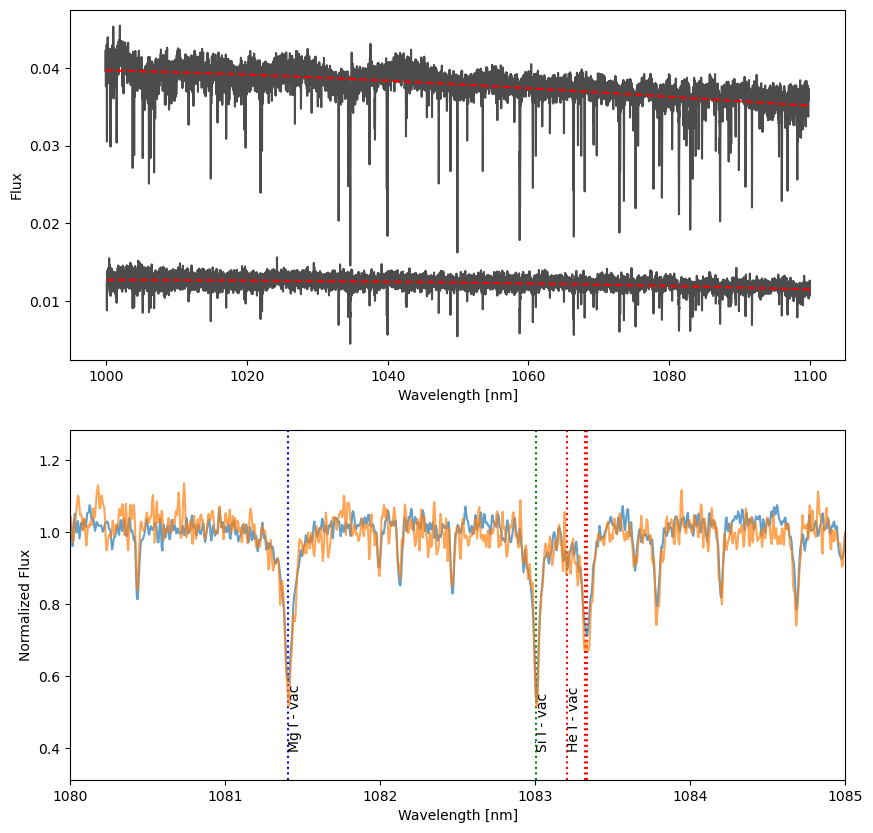

In [17]:
# Initialize plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (10,10))
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Flux')
ax2.axvline(HeI_1_vac, color='red', linestyle='dotted')
ax2.axvline(HeI_2_vac, color='red', linestyle='dotted')
ax2.axvline(HeI_3_vac, color='red', linestyle='dotted')
ax2.text(HeI_1_vac, 0.4, 'He I - vac ', rotation=90)
ax2.axvline(air_to_vac(Si_1_air), color = 'green', ls = 'dotted')
ax2.text(air_to_vac(Si_1_air), 0.4, 'Si I - vac', rotation = 90)
ax2.axvline(air_to_vac(Mg_1_air), color = 'blue', ls = 'dotted')
ax2.text(air_to_vac(Mg_1_air), 0.4,  'Mg I - vac', rotation=90)
ax2.set_xlim(1080,1085)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Normalized Flux')


for spectrum_index in range(len(fits_list[:2])): 
    spectrum = Spectrum1D(spectral_axis=spectra_array[spectrum_index,:,0]*u.nm,
                          flux = spectra_array[spectrum_index,:,1]*u.dimensionless_unscaled)
    
    continuum_fit = fit_generic_continuum(spectrum)
    continuum = continuum_fit(spectrum.spectral_axis)
    normalized_flux = spectrum.flux / continuum

    # Implement Welford's method to compute mean and variance 

    # Plot the continuum fits
    ax1.plot(spectrum.spectral_axis, spectrum.flux, c='k', alpha = 0.7)
    ax1.plot(spectrum.spectral_axis, continuum, ls = '--', c='r')


    # Plot normalized spectra 
    ax2.plot(spectrum.spectral_axis, normalized_flux, alpha = 0.7)



In [11]:
mean_profile

<Quantity [0., 0., 0., ..., 0., 0., 0.] nm>

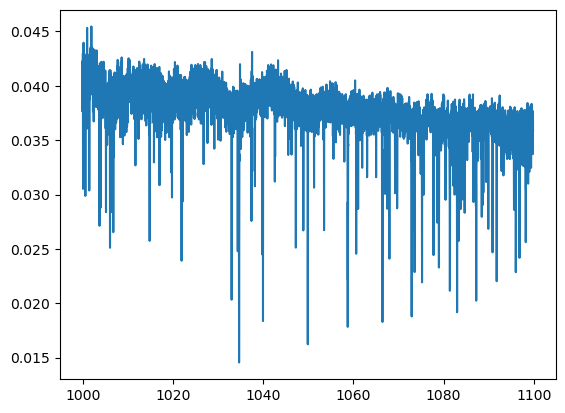

In [13]:
#test spectra 
plt.plot(spectra_array[0,:,0], spectra_array[0,:,1])

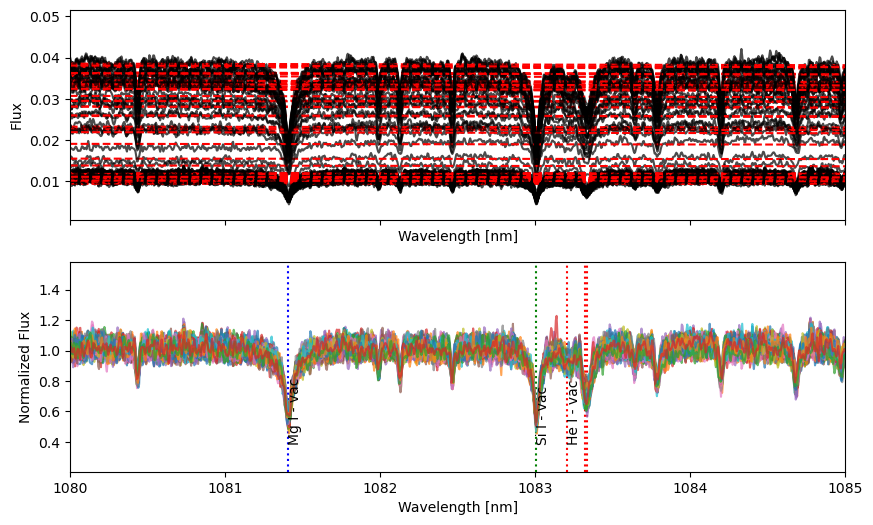

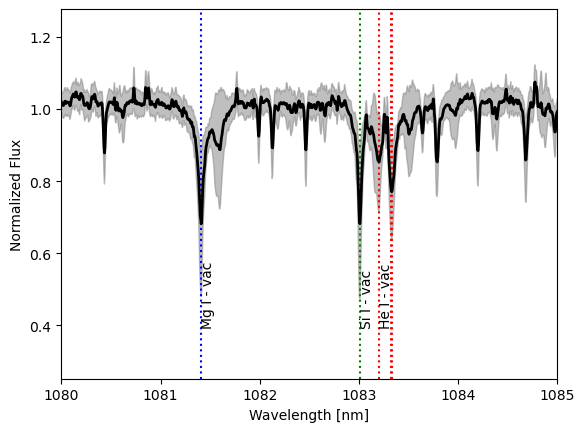

In [24]:
# Initialize running mean and variance
n_spectra = 0
mean_flux = None
m2_flux = None  # Running sum of squared differences for variance

# Set up plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Flux')
ax2.axvline(HeI_1_vac, color='red', linestyle='dotted')
ax2.axvline(HeI_2_vac, color='red', linestyle='dotted')
ax2.axvline(HeI_3_vac, color='red', linestyle='dotted')
ax2.text(HeI_1_vac, 0.4, 'He I - vac ', rotation=90)
ax2.axvline(air_to_vac(Si_1_air), color = 'green', ls = 'dotted')
ax2.text(air_to_vac(Si_1_air), 0.4, 'Si I - vac', rotation = 90)
ax2.axvline(air_to_vac(Mg_1_air), color = 'blue', ls = 'dotted')
ax2.text(air_to_vac(Mg_1_air), 0.4,  'Mg I - vac', rotation=90)
ax2.set_xlim(1080,1085)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Normalized Flux')

fig2, ax3 = plt.subplots()
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Flux')
ax3.axvline(HeI_1_vac, color='red', linestyle='dotted')
ax3.axvline(HeI_2_vac, color='red', linestyle='dotted')
ax3.axvline(HeI_3_vac, color='red', linestyle='dotted')
ax3.text(HeI_1_vac, 0.4, 'He I - vac ', rotation=90)
ax3.axvline(air_to_vac(Si_1_air), color = 'green', ls = 'dotted')
ax3.text(air_to_vac(Si_1_air), 0.4, 'Si I - vac', rotation = 90)
ax3.axvline(air_to_vac(Mg_1_air), color = 'blue', ls = 'dotted')
ax3.text(air_to_vac(Mg_1_air), 0.4,  'Mg I - vac', rotation=90)
ax3.set_xlim(1080,1085)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Normalized Flux')
ax3.legend


for spectrum_index in range(len(fits_list)): 
    # Load spectrum data
    spectrum = Spectrum1D(
        spectral_axis=spectra_array[spectrum_index, :, 0] * u.nm,
        flux=spectra_array[spectrum_index, :, 1] * u.dimensionless_unscaled
    )
    
    # Fit and normalize continuum
    continuum_fit = fit_generic_continuum(spectrum)
    continuum = continuum_fit(spectrum.spectral_axis)
    normalized_flux = spectrum.flux / continuum

    # Welford's online algorithm for mean and variance
    if mean_flux is None:
        mean_flux = np.zeros_like(normalized_flux.value)
        m2_flux = np.zeros_like(normalized_flux.value)
    
    n_spectra += 1
    delta = normalized_flux.value - mean_flux
    mean_flux += delta / n_spectra
    m2_flux += delta * (normalized_flux.value - mean_flux)

    # Plot original and fitted continuum
    ax1.plot(spectrum.spectral_axis, spectrum.flux, c='k', alpha=0.7)
    ax1.plot(spectrum.spectral_axis, continuum, ls='--', c='r')

    # Plot normalized spectra
    ax2.plot(spectrum.spectral_axis, normalized_flux, alpha=0.7)

# Compute final variance and standard deviation
variance_flux = m2_flux / (n_spectra - 1) if n_spectra > 1 else np.zeros_like(mean_flux)
std_flux = np.sqrt(variance_flux)

# Plot averaged spectrum with uncertainty
ax3.plot(spectrum.spectral_axis, mean_flux * u.dimensionless_unscaled, c='black', lw=2, label="Mean Spectrum")
ax3.fill_between(spectrum.spectral_axis.value, 
                 (mean_flux - std_flux), (mean_flux + std_flux), 
                 color="gray", alpha=0.5, label="1σ Uncertainty")
